# Bootstrapping

Bootstrapping is a statistical technique that allows us to access uncertainty about a certain point estimate. As far as we have seen in the course, whenever we wanted to calculate confidence intervals of an estimate, or calculate its standard errors, we would rely on asymptotic arguments. Those work well when we have large data sets. However, in small sample data sets, those arguments may be weaker and Boostrap methods can be useful. 

Bootstrapping consists in treating the sample we are using for point estimates as the population, so we can have access to uncertainty measures of the point estimates. In general, we would like to have confidence intervals or standard errors from some point estimate, say $\hat{\mu}$, calculated using our main sample of size $N$. To perform a bootstrap, we first have to resample our main sample $M$ times with replacement. For each of these new samples, we can calculate a new point estimate. That is, we will end up with a collection $\{\hat{\mu}^{(1)},\hat{\mu}^{(2)},\dots,\hat{\mu}^{(M)}\}$. This collection of estimates can be treated as a sample from the theoretical distribution of $\hat{\mu}$, so we can calculate it's percentiles to calculate our desired measures of uncertainty.

We can start simple by working with the simple average. Let's generate an i.i.d. sample and calculate the 5 samples average

\begin{equation*}

Y_i \sim U(0,1) 

\end{equation*}

\begin{equation*}

\mu_i = \frac{1}{2}
\quad
\sigma^2_{i} = \frac{1}{12}

\end{equation*}

\begin{equation*}

\bar{Y}=\sum_{i=1}^{5}\frac{Y_i}{5}

\end{equation*}



We can conduct a monte carlo experiment to know with high level of accuracy the small sample properties of this average.

In [55]:
N <- 10
MC_reps <- 100000

Y_hat_MC <- numeric(MC_reps)

for (i in 1:MC_reps) {
    sample <- runif(N)
    Y_hat_MC[i] <- mean(sample)
}

lower_bound_MC <- quantile(Y_hat_MC, 0.025)
upper_bound_MC <- quantile(Y_hat_MC, 0.975)

print(lower_bound_MC)
print(upper_bound_MC)

     2.5% 
0.3210373 
    97.5% 
0.6794532 


Now, let's calculate the confidence intervals using asymptotic arguments. Let's take another sample from the distribution and calculate it's average

In [56]:
Y <- runif(N)
Y_hat <- mean(Y)

By the Central Limit Theorem for i.i.d. samples (Lindeberg-Lévy), the asymptotic distribution of the sample average is 

\begin{equation*}

\bar{Y} \overset{a}{\sim} N\left(\frac{1}{2},\frac{1}{12n}\right)

\end{equation*}

We can use scipy to calculate the 95% confidence interval around the mean

In [57]:
lower_bound <- qnorm(0.025, mean = 1/2, sd = 1/(12 * N))
upper_bound <- qnorm(0.975, mean = 1/2, sd = 1/(12 * N))

In [58]:
print(lower_bound)
print(upper_bound)

[1] 0.483667
[1] 0.516333


The results are definitely not accurate

Now, let's calculate the confidence intervals using bootstrap

In [59]:
M <- 100000

Y_hat_boost <- numeric(M)

for (i in 1:M) {
    Y_boost <- sample(Y, N, replace = TRUE)
    Y_hat_boost[i] <- mean(Y_boost)
}

lower_bound_boost <- quantile(Y_hat_boost, 0.025)
upper_bound_boost <- quantile(Y_hat_boost, 0.975)

print(lower_bound_boost)
print(upper_bound_boost)

     2.5% 
0.2704985 
    97.5% 
0.5461939 


In [60]:
delta <- Y_hat_boost - Y_hat

lower_bound_hall <- Y_hat - quantile(delta, 0.975)
upper_bound_hall <- Y_hat - quantile(delta, 0.025)

print(lower_bound_hall)
print(upper_bound_hall)

    97.5% 
0.2599928 
     2.5% 
0.5356882 


The bootstrap result is fairly more accurate than the asymptotic argument.

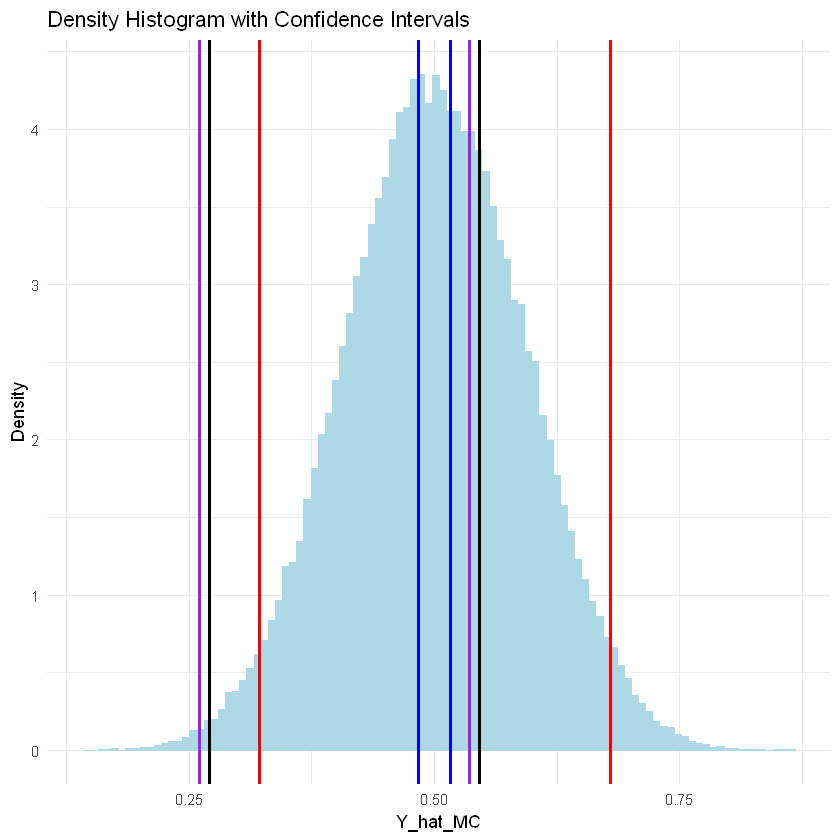

In [61]:
library(ggplot2)

# Create a data frame for plotting
df <- data.frame(Y_hat_MC = Y_hat_MC)

# Plot the histogram
ggplot(df, aes(x = Y_hat_MC)) +
  geom_histogram(aes(y = ..density..), bins = 100, fill = "lightblue", color = "lightblue") +
  
  # Add vertical lines for confidence intervals
  geom_vline(xintercept = lower_bound_MC, color = 'red',  size = 1, show.legend = TRUE) +
  geom_vline(xintercept = upper_bound_MC, color = 'red',  size = 1) +
  
  geom_vline(xintercept = lower_bound, color = 'blue',  size = 1) +
  geom_vline(xintercept = upper_bound, color = 'blue',  size = 1) +
  
  geom_vline(xintercept = lower_bound_boost, color = 'black', size = 1) +
  geom_vline(xintercept = upper_bound_boost, color = 'black', size = 1) +
  
  geom_vline(xintercept = lower_bound_hall, color = 'purple', size = 1) +
  geom_vline(xintercept = upper_bound_hall, color = 'purple', size = 1) +
  
  # Add legend and labels
  labs(title = "Density Histogram with Confidence Intervals",
       x = "Y_hat_MC", 
       y = "Density") +
  theme_minimal()

What about linear regression? We can perform the same task we did with the plain average. For simplicity, let's generate data from a bivariate linear regression:

\begin{equation*}

Y_i = 2+ 3 x_i + \varepsilon_i

\end{equation*}

\begin{equation*}

x_i \sim U(0,1)

\end{equation*}

\begin{equation*}

\varepsilon_i \sim N(0,1)
\end{equation*}

\begin{equation*}

\hat{\beta} = (X^\prime X)^{-1}(X^\prime Y)
\end{equation*}

In [62]:
beta_0 <- 2
beta_1 <- 3
x <- runif(N, min = 0, max = 1)

Then, we conduct the monte carlo experiment to know with high level of accuracy the small sample properties of this average

In [63]:
MC_reps <- 100000

beta_hat_MC <- matrix(0, nrow = MC_reps, ncol = 2)

for (i in 1:MC_reps) {
    e_MC <- rnorm(N, mean = 0, sd = 1)
    Y_MC <- 2 + 3 * x + e_MC

    model_MC <- lm(Y_MC ~ x)
    
    beta_hat_MC[i, ] <- c(coef(model_MC)[1], coef(model_MC)[2])
}

In [64]:
lower_bound_b0_MC <- quantile(beta_hat_MC[, 1], 0.025)
upper_bound_b0_MC <- quantile(beta_hat_MC[, 1], 0.975)

lower_bound_b1_MC <- quantile(beta_hat_MC[, 2], 0.025)
upper_bound_b1_MC <- quantile(beta_hat_MC[, 2], 0.975)

# Print results
cat("b0\n")
cat(lower_bound_b0_MC, "\n")
cat(upper_bound_b0_MC, "\n")
cat("--------------------\n")
cat("b1\n")
cat(lower_bound_b1_MC, "\n")
cat(upper_bound_b1_MC, "\n")


b0
0.9375001 
3.053342 


--------------------
b1
0.8253716 
5.200885 


Now, let's calculate the confidence intervals using asymptotic arguments. Let's take another sample from the DGP and estimate the coefficients

In [65]:
Y <- 2 + 3 * x + rnorm(N, mean = 0, sd = 1)
model_hat <- lm(Y ~ x)
beta_hat <- c(coef(model_hat)[1], coef(model_hat)[2])

By the Central Limit Theorem for linear regression, the asymptotic distribution of the coefficients is

\begin{equation*}

\hat{\beta} \overset{a}{\sim} N\left(\beta,\sigma^2(X^\prime X)^{-1}\right)

\end{equation*}

Where

\begin{equation*}

\sigma^2 = 1

\end{equation*}

\begin{equation*}

\beta = (2,3)^\prime

\end{equation*}

In [66]:
X <- cbind(1, x)  # Create a matrix with a column of ones and x

cov_betas <- solve(t(X) %*% X)  # Calculate the covariance matrix

lower_bound_b0 <- qnorm(0.025, mean = beta_0, sd = sqrt(cov_betas[1, 1]))
upper_bound_b0 <- qnorm(0.975, mean = beta_0, sd = sqrt(cov_betas[1, 1]))

lower_bound_b1 <- qnorm(0.025, mean = beta_1, sd = sqrt(cov_betas[2, 2]))
upper_bound_b1 <- qnorm(0.975, mean = beta_1, sd = sqrt(cov_betas[2, 2]))

In [67]:
cat("b0 ols\n")
cat(lower_bound_b0, "\n")
cat(upper_bound_b0, "\n")
cat("--------------------\n")
cat("b1 ols\n")
cat(lower_bound_b1, "\n")
cat(upper_bound_b1, "\n")

b0 ols
0.9431599 
3.05684 
--------------------
b1 ols
0.8128087 
5.187191 


To perform a bootstrap for linear regression, there exist at least four methods: empirical/paired bootstrap, residual based bootstrap, wild bootstrap and block bootstrap . The first and second methods are the most commonly used when the basic assumptions of OLS hold (Gauss-Markov theorem). The third and four methods tackle the issues arising from heteroskedasticity and serial correlation. We will stick with the first approach due to it's similarity with the simple average procedure.

In [68]:
M <- 100000

beta_hat_boost <- matrix(0, nrow = M, ncol = 2)

for (i in 1:M) {
    Z <- cbind(x, Y)  # Combine x and Y into a matrix
    random_index <- sample(1:N, N, replace = TRUE)  # Randomly sample indices
    Z_boost <- Z[random_index, ]  # Create bootstrap sample
    
    model_boost <- lm(Z_boost[, 2] ~ Z_boost[, 1])  # Fit the model
    beta_hat_boost[i, ] <- c(coef(model_boost)[1], coef(model_boost)[2])  # Store coefficients
}

# Calculate confidence intervals
lower_bound_b0_boost <- quantile(beta_hat_boost[, 1], 0.025)
upper_bound_b0_boost <- quantile(beta_hat_boost[, 1], 0.975)

lower_bound_b1_boost <- quantile(beta_hat_boost[, 2], 0.025)
upper_bound_b1_boost <- quantile(beta_hat_boost[, 2], 0.975)

# Print results
cat("b0 simple bootstrap\n")
cat(lower_bound_b0_boost, "\n")
cat(upper_bound_b0_boost, "\n")
cat("--------------------\n")
cat("b1 simple bootstrap\n")
cat(lower_bound_b1_boost, "\n")
cat(upper_bound_b1_boost, "\n")

b0 simple bootstrap
1.279174 
3.146069 
--------------------
b1 simple bootstrap
0.9082533 
4.418698 


In [69]:
delta_b0 <- beta_hat_boost[, 1] - beta_hat[1]  # Calculate differences for b0
delta_b1 <- beta_hat_boost[, 2] - beta_hat[2]  # Calculate differences for b1

# Calculate Hall confidence intervals
lower_bound_b0_hall <- beta_hat[1] - quantile(delta_b0, 0.975)
upper_bound_b0_hall <- beta_hat[1] - quantile(delta_b0, 0.025)

lower_bound_b1_hall <- beta_hat[2] - quantile(delta_b1, 0.975)
upper_bound_b1_hall <- beta_hat[2] - quantile(delta_b1, 0.025)

In [70]:
cat("b0 empirical bootstrap\n")
cat(lower_bound_b0_hall, "\n")
cat(upper_bound_b0_hall, "\n")
cat("--------------------\n")
cat("b1 empirical bootstrap\n")
cat(lower_bound_b1_hall, "\n")
cat(upper_bound_b1_hall, "\n")

b0 empirical bootstrap
1.168706 
3.035601 
--------------------
b1 empirical bootstrap
0.9387422 
4.449187 


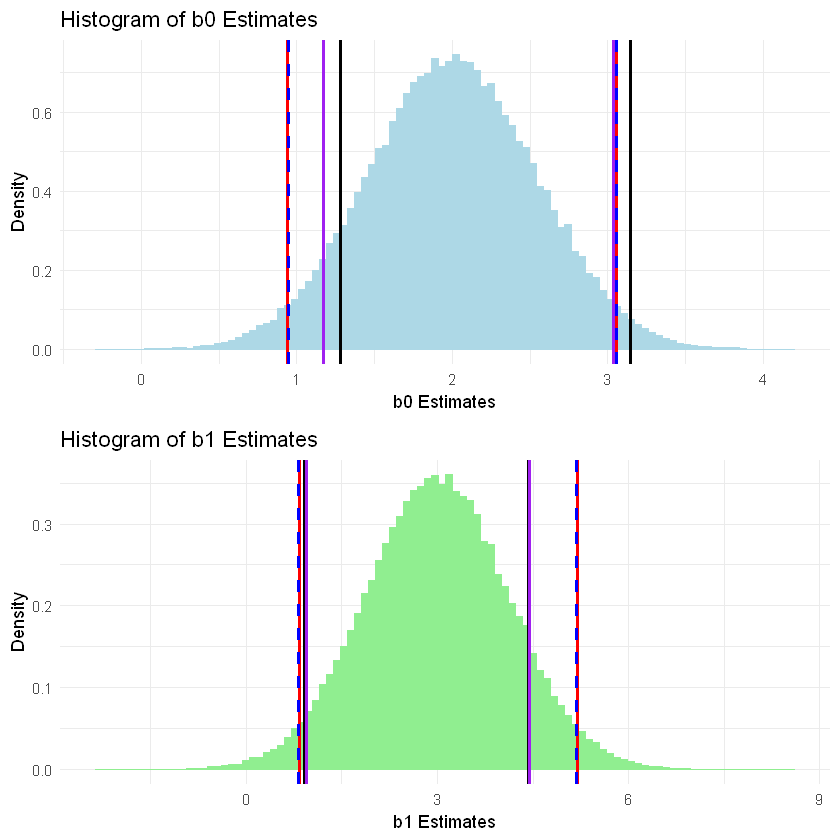

In [71]:
library(ggplot2)
library(gridExtra)

# Create data frames for b0 and b1
df_b0 <- data.frame(beta_hat_MC = beta_hat_MC[, 1])
df_b1 <- data.frame(beta_hat_MC = beta_hat_MC[, 2])

# Histogram for b0
p1 <- ggplot(df_b0, aes(x = beta_hat_MC)) +
  geom_histogram(bins = 100, aes(y = ..density..), fill = "lightblue", color = "lightblue") +
  geom_vline(xintercept = lower_bound_b0_MC, color = "red", size = 1) +
  geom_vline(xintercept = upper_bound_b0_MC, color = "red", size = 1) +
  geom_vline(xintercept = lower_bound_b0, color = "blue", linetype = 'dashed',size = 1) +
  geom_vline(xintercept = upper_bound_b0, color = "blue", linetype = 'dashed',size = 1) +
  geom_vline(xintercept = lower_bound_b0_boost, color = "black", size = 1) +
  geom_vline(xintercept = upper_bound_b0_boost, color = "black",  size = 1) +
  geom_vline(xintercept = lower_bound_b0_hall, color = "purple",  size = 1) +
  geom_vline(xintercept = upper_bound_b0_hall, color = "purple", size = 1) +
  labs(title = "Histogram of b0 Estimates", x = "b0 Estimates", y = "Density") +
  theme_minimal()

# Histogram for b1
p2 <- ggplot(df_b1, aes(x = beta_hat_MC)) +
  geom_histogram(bins = 100, aes(y = ..density..), fill = "lightgreen", color = "lightgreen") +
  geom_vline(xintercept = lower_bound_b1_MC, color = "red", size = 1) +
  geom_vline(xintercept = upper_bound_b1_MC, color = "red", size = 1) +
  geom_vline(xintercept = lower_bound_b1, color = "blue", linetype = 'dashed',  size = 1) +
  geom_vline(xintercept = upper_bound_b1, color = "blue", linetype = 'dashed',  size = 1) +
  geom_vline(xintercept = lower_bound_b1_boost, color = "black", size = 1) +
  geom_vline(xintercept = upper_bound_b1_boost, color = "black", size = 1) +
  geom_vline(xintercept = lower_bound_b1_hall, color = "purple", size = 1) +
  geom_vline(xintercept = upper_bound_b1_hall, color = "purple", size = 1) +
  labs(title = "Histogram of b1 Estimates", x = "b1 Estimates", y = "Density") +
  theme_minimal()

# Arrange the plots
grid.arrange(p1, p2, ncol = 1)
